In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

/Users/noahs/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, input_dim // 2)
        self.decoder = nn.Linear(input_dim // 2, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded


In [3]:
def generate_synthetic_data(num_samples, num_features, sparsity):
    data = torch.zeros(num_samples, num_features)
    mask = torch.rand(num_samples, num_features) < sparsity
    data[mask] = torch.rand(mask.sum())
    return data

def importance_weighted_mse_loss(output, target, importance):
    return torch.mean(importance * (output - target) ** 2)

In [4]:

# Hyperparameters
num_samples = 100_000
num_features = 128
sparsity = 1/32
learning_rate = 0.001
num_epochs = 200

# Generate synthetic data
data = generate_synthetic_data(num_samples, num_features, sparsity)

# Create model, loss function, and optimizer
model = SparseAutoencoder(num_features)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

importance_weights = 1.0 ** torch.arange(num_features, dtype=torch.float32)

Epoch [10/200], Loss: 0.0132
Epoch [20/200], Loss: 0.0111
Epoch [30/200], Loss: 0.0100
Epoch [40/200], Loss: 0.0092
Epoch [50/200], Loss: 0.0087
Epoch [60/200], Loss: 0.0081
Epoch [70/200], Loss: 0.0076
Epoch [80/200], Loss: 0.0071
Epoch [90/200], Loss: 0.0066
Epoch [100/200], Loss: 0.0063
Epoch [110/200], Loss: 0.0060
Epoch [120/200], Loss: 0.0057
Epoch [130/200], Loss: 0.0056
Epoch [140/200], Loss: 0.0054
Epoch [150/200], Loss: 0.0053
Epoch [160/200], Loss: 0.0052
Epoch [170/200], Loss: 0.0052
Epoch [180/200], Loss: 0.0052
Epoch [190/200], Loss: 0.0051
Epoch [200/200], Loss: 0.0051


/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_86965/1484547941.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


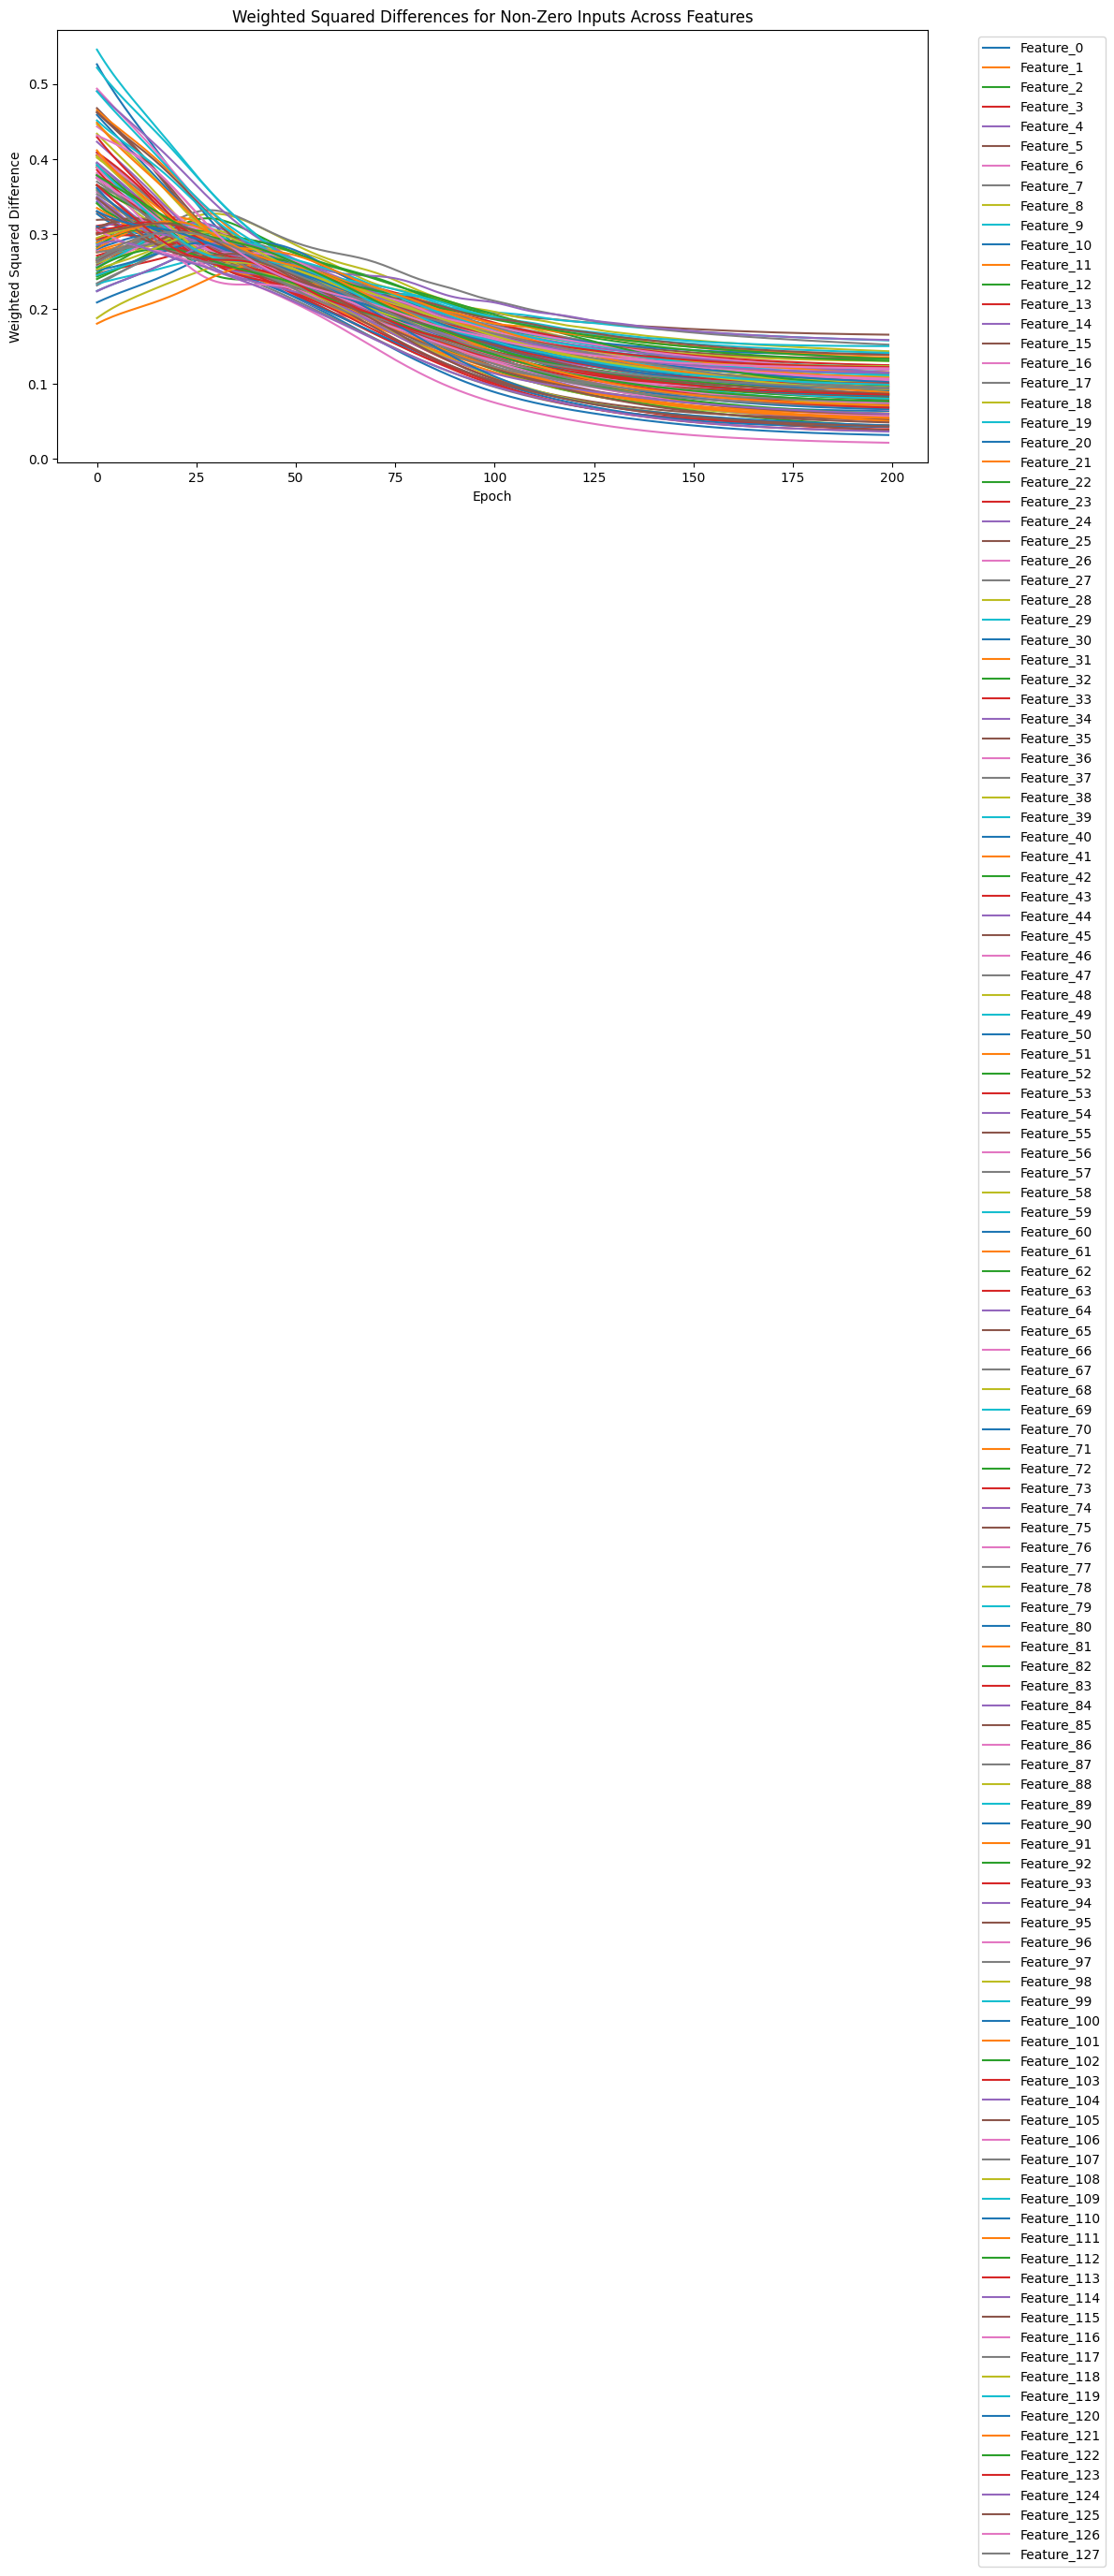

In [5]:
# DataFrame to store weighted squared differences
df = pd.DataFrame(columns=[f'Feature_{i}' for i in range(num_features)])

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(data)
    loss = importance_weighted_mse_loss(outputs, data, importance_weights)
    
    loss.backward()
    optimizer.step()
    
    # Calculate weighted squared differences for non-zero inputs
    with torch.no_grad():
        non_zero_mask = data != 0
        weighted_sq_diff = (outputs - data) ** 2
        weighted_sq_diff_nonzero = weighted_sq_diff[non_zero_mask]
        
        # Compute mean for each feature
        feature_means = torch.zeros(num_features)
        for i in range(num_features):
            feature_mask = non_zero_mask[:, i]
            if feature_mask.sum() > 0:
                feature_means[i] = weighted_sq_diff[:, i][feature_mask].mean()
        
        # Add to DataFrame
        df.loc[epoch] = feature_means.numpy()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Create and display the graph
plt.figure(figsize=(12, 6))
for feature in df.columns:
    plt.plot(df.index, df[feature], label=feature)

plt.title('Weighted Squared Differences for Non-Zero Inputs Across Features')
plt.xlabel('Epoch')
plt.ylabel('Weighted Squared Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
model.eval()
with torch.no_grad():
    test_data = generate_synthetic_data(1, num_features, sparsity)
    reconstructed = model(test_data)
    test_loss = importance_weighted_mse_loss(reconstructed, test_data, importance_weights)
    print(f"Test Loss: {test_loss.item():.4f}")
    
    # Print non-zero input and output values
    for i in range(len(test_data)):
        print(f"\nSample {i}:")
        
        # Non-zero input values
        non_zero_mask = test_data[i] != 0
        non_zero_values, non_zero_indices = test_data[i][non_zero_mask].sort(descending=True)
        non_zero_indices = non_zero_mask.nonzero().flatten()[non_zero_indices]
        
        print("Non-zero input dimensions (sorted by value):")
        if len(non_zero_indices) == 0:
            print("  No non-zero inputs")
        else:
            for idx, value in zip(non_zero_indices, non_zero_values):
                print(f"  Index {idx.item()}: {value.item():.4f}")
        
        # Number of non-zero inputs
        n = len(non_zero_indices)

        # Highest n output dimensions
        _, top_n_indices = torch.topk(reconstructed[i], n)
        print(f"\nTop {n} output dimensions:")
        for idx in top_n_indices:
            print(f"  Index {idx.item()}: {reconstructed[i][idx].item():.4f}")
        
        # Non-zero output values
        non_zero_outputs = reconstructed[i].nonzero().flatten()
        print("Non-zero output dimensions:")
        if len(non_zero_outputs) == 0:
            print("  No non-zero outputs")
        else:
            for idx in non_zero_outputs:
                print(f"  Index {idx.item()}: {reconstructed[i][idx].item():.4f}")

Test Loss: 0.0066

Sample 0:
Non-zero input dimensions (sorted by value):
  Index 91: 0.8067
  Index 117: 0.7983
  Index 60: 0.4957
  Index 63: 0.3470
  Index 125: 0.2947
  Index 114: 0.1803
  Index 71: 0.1173

Top 7 output dimensions:
  Index 60: 0.3923
  Index 117: 0.3787
  Index 91: 0.3297
  Index 63: 0.2199
  Index 125: 0.1526
  Index 11: 0.1494
  Index 92: 0.1341
Non-zero output dimensions:
  Index 0: -0.0064
  Index 1: 0.1323
  Index 2: 0.0037
  Index 3: 0.0666
  Index 4: -0.0276
  Index 5: -0.0321
  Index 6: -0.0431
  Index 7: 0.0180
  Index 8: -0.0267
  Index 9: -0.0466
  Index 10: 0.0857
  Index 11: 0.1494
  Index 12: -0.0437
  Index 13: 0.0007
  Index 14: -0.0079
  Index 15: 0.0280
  Index 16: -0.0719
  Index 17: 0.0362
  Index 18: -0.0031
  Index 19: -0.0240
  Index 20: 0.0036
  Index 21: -0.0511
  Index 22: -0.0002
  Index 23: 0.0385
  Index 24: -0.0186
  Index 25: 0.0031
  Index 26: -0.0797
  Index 27: 0.0042
  Index 28: 0.0400
  Index 29: 0.0477
  Index 30: 0.0746
  Index

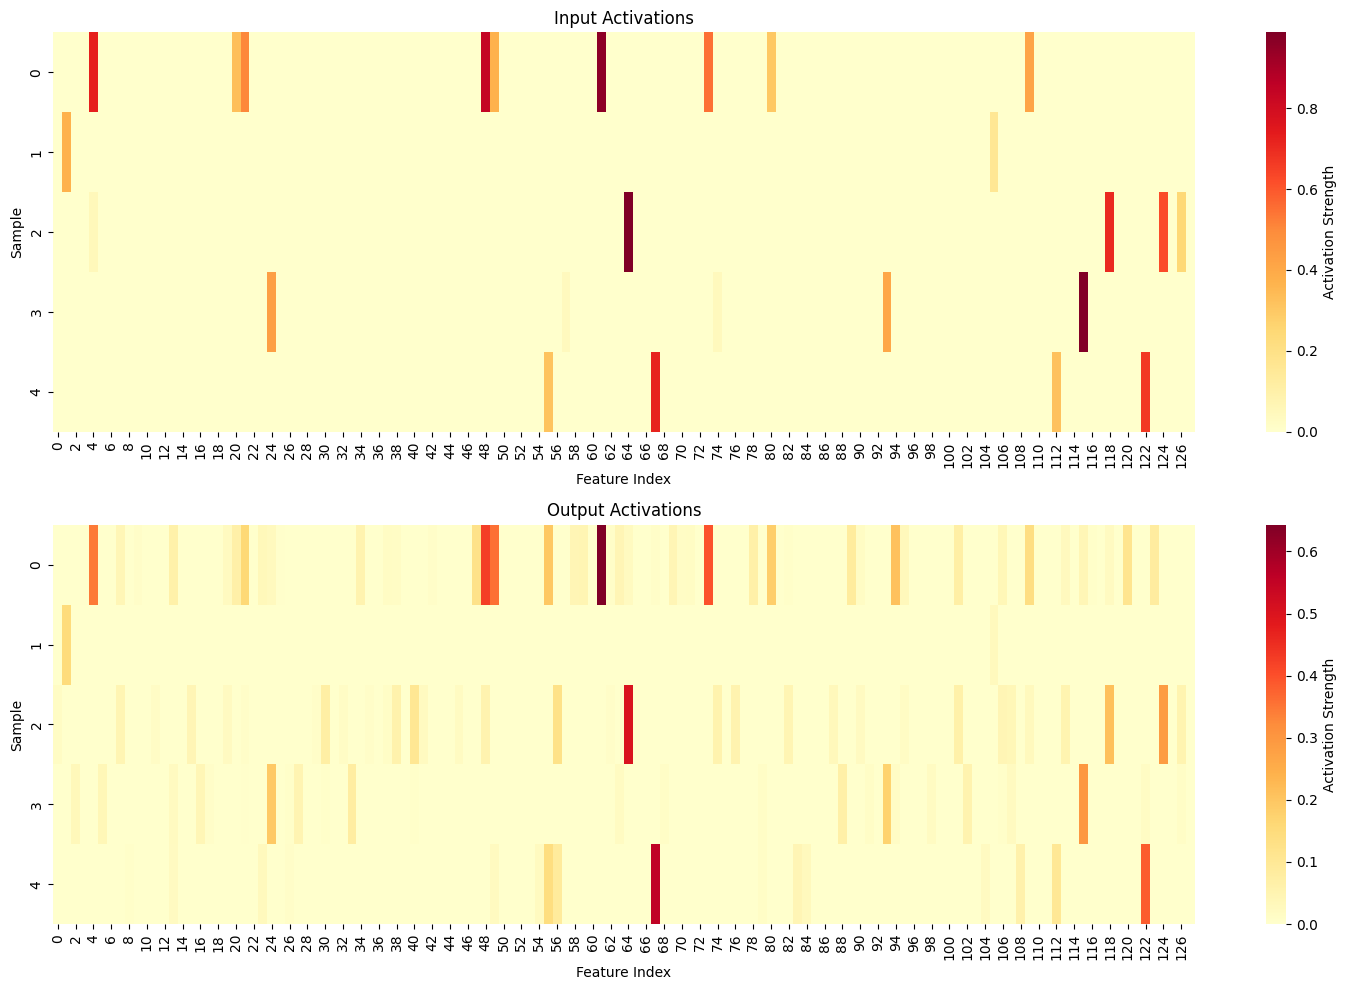

Input Sparsity: 95.94%
Output Sparsity: 80.00%
Activation Similarity: 95.78%


In [322]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_activation_data(model, num_samples, num_features, sparsity):
    input_activations = np.zeros((num_samples, num_features))
    output_activations = np.zeros((num_samples, num_features))
    
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            test_data = generate_synthetic_data(1, num_features, sparsity)
            reconstructed = model(test_data)
            
            # Record input activations
            input_activations[i] = test_data.numpy().flatten()
            
            # Record output activations, setting negative values to 0
            output_activations[i] = np.maximum(reconstructed.numpy().flatten()-0.05, 0)
    
    return input_activations, output_activations

def plot_activation_heatmap(input_activations, output_activations):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Input activations heatmap
    sns.heatmap(input_activations, ax=ax1, cmap="YlOrRd", cbar_kws={'label': 'Activation Strength'})
    ax1.set_title("Input Activations")
    ax1.set_xlabel("Feature Index")
    ax1.set_ylabel("Sample")
    
    # Output activations heatmap
    sns.heatmap(output_activations, ax=ax2, cmap="YlOrRd", cbar_kws={'label': 'Activation Strength'})
    ax2.set_title("Output Activations")
    ax2.set_xlabel("Feature Index")
    ax2.set_ylabel("Sample")
    
    plt.tight_layout()
    plt.show()

# Generate data for heatmap
num_samples_for_heatmap = 5
input_activations, output_activations = generate_activation_data(model, num_samples_for_heatmap, num_features, sparsity)

# Plot heatmap
plot_activation_heatmap(input_activations, output_activations)

# Calculate and print some statistics
input_sparsity = (input_activations == 0).mean()
output_sparsity = (output_activations == 0).mean()
activation_similarity = np.mean(np.abs(input_activations - output_activations) < 0.1)

print(f"Input Sparsity: {input_sparsity:.2%}")
print(f"Output Sparsity: {output_sparsity:.2%}")
print(f"Activation Similarity: {activation_similarity:.2%}")